In [14]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from tqdm import tqdm
from src.tools import load_dataset
import numpy as np
import wandb

In [15]:
inner_iters = 10000
batch_size = 32
vocab_size = 256

IMG_SIZE = 32
IMG_CHANNELS = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
from src.tools import load_dataset
sampler3, test_sampler3, loader3, test_loader3 = load_dataset('MNIST-colored_3', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
sampler2, test_sampler2, loader2, test_loader2 = load_dataset('MNIST-colored_2', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
Y_sampler = sampler3
X_sampler = sampler2

def sampler_0(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = X_sampler.sample(batch_size)
    # x_end = x_end.view(batch_size, -1).mul(0.5).add(0.5).clip(0,1)*255
    x_end = x_end.mul(0.5).add(0.5).clip(0,1)*255
    return x_end.long()

def sampler_1(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = Y_sampler.sample(batch_size)
    # x_end = x_end.view(batch_size, -1).mul(0.5).add(0.5).clip(0,1)*255
    x_end = x_end.mul(0.5).add(0.5).clip(0,1)*255
    return x_end.long()

In [17]:
# wandb.login('')

In [18]:
# wandb.init(project="CIPF") project/subproject/SMILES/csbm/csbm/src/csbm/data.py

In [20]:
from csbm.src.csbm.models.images import UNet
from csbm.src.csbm.data import Prior
from typing import Optional, Tuple
import torch.nn.functional as F

ImportError: cannot import name 'Prior' from 'csbm.data' (unknown location)

In [10]:
! pip install omegaconf 

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement omegaconf (from versions: none)
ERROR: No matching distribution found for omegaconf


In [ ]:
class ImageD3PM(nn.Module):
    def __init__(
        self, 
        input_dim: int = 32,
        num_categories: int = 256,
        num_timesteps: int = 100, 
        in_channels: int = 3, 
        num_channels: int = 64, 
        num_layers: int = 2,
        ch_mults: Tuple[int, ...] = (1, 2, 2, 2),
        attention_resolution: int = 16,
        num_groups: int = 32,
        num_att_heads: int = 4,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self.d = 32*32*3
        self.model = UNet(
            input_dim,
            num_categories,
            in_channels,
            64,
            num_layers,
            ch_mults,
            attention_resolution,
            num_groups,
            num_att_heads,
            dropout
        )
        self.num_categories = num_categories
        self.num_timesteps = num_timesteps

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x_one_hot = F.one_hot(x, self.num_categories) 
        mean = (self.num_categories - 1) / 2
        x = x / mean - 1
        # print(x_one_hot.shape)
        return self.model(x, (t*100).int()+1) + x_one_hot

# Training

In [10]:
model_f = ImageD3PM(input_dim = 32,
        num_categories = 256,
        num_timesteps = 100).to(device)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-4)

model_b = ImageD3PM(input_dim = 32,
        num_categories = 256,
        num_timesteps = 100).to(device)
optim_b = torch.optim.Adam(model_b.parameters(), lr=1e-4)

print('denoiser params:', np.sum([np.prod(p.shape) for p in model_f.parameters()]))

denoiser params: 34780608


In [11]:
# def sample_from_model(x, model, batch_size):
#     with torch.no_grad():
#         t = 0.0
        # while t < 1 - 1e-3:
        #     p1 = torch.softmax(model(x, torch.ones(batch_size).to(device) * t), dim=-1)
        #     h = min(0.01, 1.0 - t)
        #     one_hot_x_t = nn.functional.one_hot(x, vocab_size).float()
        #     u = (p1 - one_hot_x_t) / (1.0 - t)
        #     x = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        #     t += h
#     return x

In [ ]:
prior = Prior(
    alpha=0.01, 
    num_categories=256, 
    num_timesteps=100, 
    num_skip_steps=2, 
    prior_type='gaussian',
    eps=1e-6,
    centroids=None,
    dtype=torch.float32,
)

In [12]:
def train_with_data(model, optim, type='f'):
    for iter in tqdm(range(inner_iters)):
    # for iter in range(inner_iters):
        t = torch.rand(batch_size).to(device)
        if type=='f':
            x_1 = sampler_1(batch_size).view(batch_size, -1)
            x_0 = sampler_0(batch_size).view(batch_size, -1)
            x_t = torch.where(torch.rand(batch_size, model.d).to(device) <  t[:, None], x_1, x_0)
        else:
            x_0 = sampler_0(batch_size).view(batch_size, -1)
            x_1 = sampler_1(batch_size).view(batch_size, -1)
            x_t = torch.where(torch.rand(batch_size, model.d).to(device) <  t[:, None], x_0, x_1)
        
#         x_t = x_t.view(x_1.shape[0], IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
#         logits = model(x_t, t)
        
#         if type=='f':
#             loss = nn.functional.cross_entropy(logits.permute(0, 4, 1, 2, 3).reshape(x_1.shape[0], 256, -1), x_1).mean()
#         else:
#             loss = nn.functional.cross_entropy(logits.permute(0, 4, 1, 2, 3).reshape(x_1.shape[0], 256, -1), x_0).mean()
            
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
        
        if (iter+1) % 1000 == 0:
            print('Loss:', loss.item())
            visualize(sampler_0, model_f)

In [43]:
# def train_with_model(model, optim, sample_model, type='f'):
#     # for iter in tqdm(range(inner_iters)):
#     for iter in range(inner_iters):
#         t = torch.rand(batch_size).to(device)
#         if type=='f':
#             x_1 = sampler_1(batch_size)
#             x_0 = sample_from_model(x_1, sample_model, batch_size)
#             x_t = torch.where(torch.rand(batch_size, model.d).to(device) <  t[:, None], x_1, x_0)
#         else:
#             x_0 = sampler_0(batch_size)
#             x_1 = sample_from_model(x_0, sample_model, batch_size)
#             x_t = torch.where(torch.rand(batch_size, model.d).to(device) <  t[:, None], x_0, x_1)
        

#         logits = model(x_t, t)
        
#         if type=='f':
#             loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
#         else:
#             loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_0.flatten(0, 1)).mean()
            
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
        
#         if (iter+1)%100==0:
#             print('Loss:', loss.item())

# Sampling

In [44]:
def cost(results):
    costs = 0
    for i in range(len(results)-1):
        costs += (results[i][0] != results[i+1][0]).float().mean()
    
    return costs

In [45]:
def visualize(sampler, model):
    N = 10

    x_t = sampler(N)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-4:
        p1 = torch.softmax(model(x_t, torch.ones(N, dtype=torch.int32).to(device) * t), dim=-1)
        h = min(0.1, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))

    x_1 = results[-1][0]
    
    fig, axes = plt.subplots(1, 11, figsize=(10, 5))
    
    for i, el in enumerate(results):
        data = el[0].view(N, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        axes[i].axis('off')
        axes[i].imshow(data.to('cpu').permute(0,2,3,1)[0].numpy().clip(0,255))

    plt.tight_layout()
    plt.show()
    print('OT cost:', cost(results))

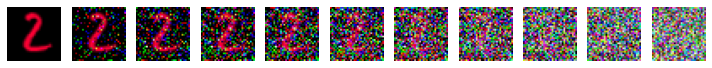

OT cost: tensor(2.8986, device='cuda:0')


In [46]:
visualize(sampler_0, model_f)
# visualize(sampler_1, model_b)

In [51]:
train_with_data(model_f, optim_f, 'f')
visualize(sampler_0, model_f)

 10%|▉         | 999/10000 [00:12<01:52, 80.19it/s] 


NameError: name 'loss' is not defined

 10%|▉         | 999/10000 [03:20<1:03:31,  2.36it/s]

Loss: 0.8199357986450195


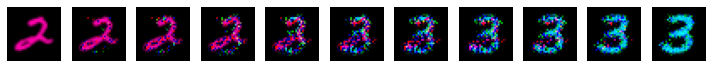

 10%|█         | 1001/10000 [03:22<1:18:11,  1.92it/s]

OT cost: tensor(0.7005, device='cuda:0')


 20%|█▉        | 1999/10000 [07:04<25:45,  5.18it/s]  

Loss: 0.8189951777458191


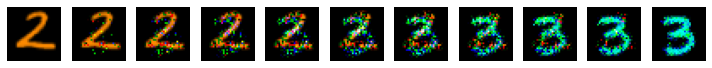

 20%|██        | 2001/10000 [07:05<40:55,  3.26it/s]

OT cost: tensor(0.7318, device='cuda:0')


 30%|██▉       | 2999/10000 [10:25<19:26,  6.00it/s]  

Loss: 0.8232716917991638


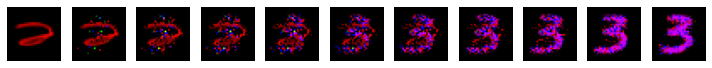

 30%|███       | 3001/10000 [10:26<34:05,  3.42it/s]

OT cost: tensor(0.7184, device='cuda:0')


 40%|███▉      | 3999/10000 [13:46<16:46,  5.96it/s]

Loss: 0.7657468318939209


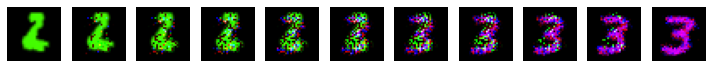

 40%|████      | 4001/10000 [13:47<42:35,  2.35it/s]

OT cost: tensor(0.7453, device='cuda:0')


 50%|████▉     | 4999/10000 [17:09<17:12,  4.85it/s]  

Loss: 0.7803711891174316


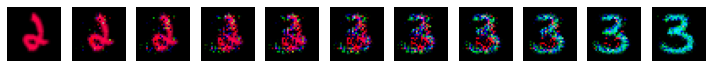

 50%|█████     | 5001/10000 [17:10<27:31,  3.03it/s]

OT cost: tensor(0.6813, device='cuda:0')


 60%|█████▉    | 5999/10000 [20:29<12:11,  5.47it/s]

Loss: 0.7800512313842773


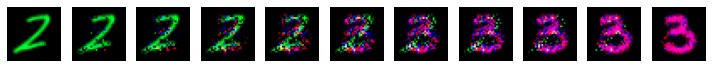

 60%|██████    | 6001/10000 [20:30<20:10,  3.30it/s]

OT cost: tensor(0.7416, device='cuda:0')


 70%|██████▉   | 6999/10000 [23:49<08:20,  6.00it/s]

Loss: 0.7703858017921448


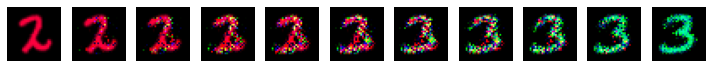

 70%|███████   | 7000/10000 [23:51<28:43,  1.74it/s]

OT cost: tensor(0.7592, device='cuda:0')


 80%|███████▉  | 7999/10000 [27:12<05:40,  5.87it/s]

Loss: 0.7551316618919373


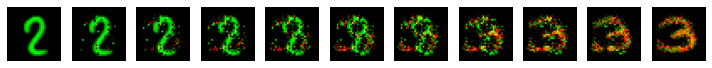

 80%|████████  | 8001/10000 [27:13<10:33,  3.15it/s]

OT cost: tensor(0.7524, device='cuda:0')


 90%|████████▉ | 8999/10000 [30:36<02:55,  5.72it/s]

Loss: 0.748202383518219


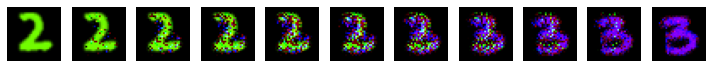

 90%|█████████ | 9001/10000 [30:37<04:54,  3.39it/s]

OT cost: tensor(0.7772, device='cuda:0')


100%|█████████▉| 9999/10000 [33:59<00:00,  5.81it/s]

Loss: 0.724745512008667


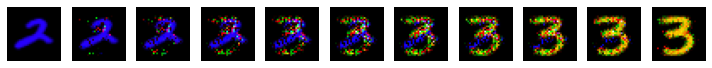

100%|██████████| 10000/10000 [34:00<00:00,  4.90it/s]

OT cost: tensor(0.7278, device='cuda:0')


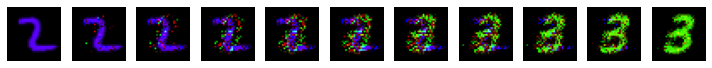

OT cost: tensor(0.7225, device='cuda:0')


In [17]:
train_with_data(model_f, optim_f, 'f')
visualize(sampler_0, model_f)

In [19]:
torch.save(model_f, 'model_f.pt')

 10%|▉         | 999/10000 [03:19<1:03:30,  2.36it/s]

Loss: 0.7650495171546936


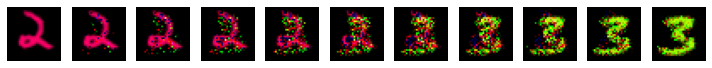

 10%|█         | 1001/10000 [03:20<1:03:48,  2.35it/s]

OT cost: tensor(0.7427, device='cuda:0')


 20%|█▉        | 1999/10000 [06:42<35:17,  3.78it/s]  

Loss: 0.7650559544563293


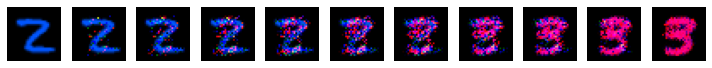

 20%|██        | 2001/10000 [06:43<45:28,  2.93it/s]

OT cost: tensor(0.7618, device='cuda:0')


 30%|██▉       | 2999/10000 [10:01<19:51,  5.88it/s]  

Loss: 0.7255646586418152


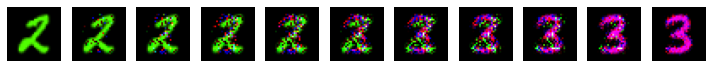

 30%|███       | 3001/10000 [10:02<38:13,  3.05it/s]

OT cost: tensor(0.7570, device='cuda:0')


 40%|███▉      | 3999/10000 [13:22<16:54,  5.91it/s]

Loss: 0.7448451519012451


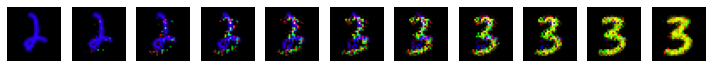

 40%|████      | 4001/10000 [13:24<37:31,  2.66it/s]

OT cost: tensor(0.7007, device='cuda:0')


 50%|████▉     | 4999/10000 [16:43<23:08,  3.60it/s]  

Loss: 0.7529222369194031


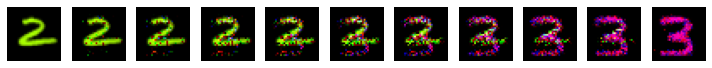

 50%|█████     | 5001/10000 [16:44<29:09,  2.86it/s]

OT cost: tensor(0.7524, device='cuda:0')


 60%|█████▉    | 5999/10000 [20:02<12:39,  5.26it/s]

Loss: 0.6991791725158691


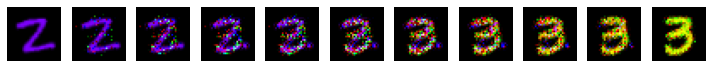

 60%|██████    | 6001/10000 [20:03<21:40,  3.07it/s]

OT cost: tensor(0.7443, device='cuda:0')


 70%|██████▉   | 6999/10000 [23:24<08:22,  5.97it/s]

Loss: 0.734610378742218


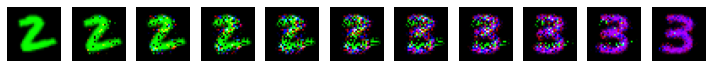

 70%|███████   | 7001/10000 [23:26<20:24,  2.45it/s]

OT cost: tensor(0.7684, device='cuda:0')


 80%|███████▉  | 7999/10000 [26:46<05:39,  5.89it/s]

Loss: 0.7183851599693298


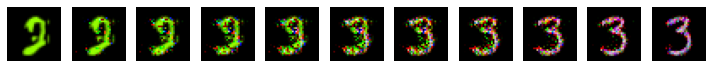

 80%|████████  | 8001/10000 [26:47<10:30,  3.17it/s]

OT cost: tensor(0.7029, device='cuda:0')


 90%|████████▉ | 8999/10000 [30:08<03:43,  4.47it/s]

Loss: 0.6896920800209045


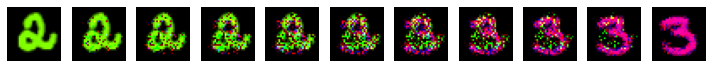

 90%|█████████ | 9001/10000 [30:10<08:10,  2.04it/s]

OT cost: tensor(0.7564, device='cuda:0')


100%|█████████▉| 9999/10000 [33:31<00:00,  5.87it/s]

Loss: 0.7206975817680359


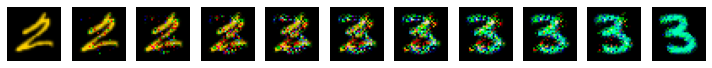

100%|██████████| 10000/10000 [33:32<00:00,  4.97it/s]

OT cost: tensor(0.7322, device='cuda:0')


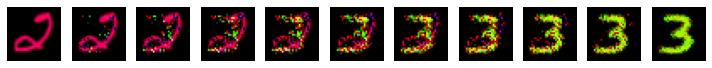

OT cost: tensor(0.7494, device='cuda:0')


In [20]:
train_with_data(model_f, optim_f, 'f')
visualize(sampler_0, model_f)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.293618083000183
Loss: 1.303389072418213
Loss: 1.2402673959732056
Loss: 1.2120741605758667
Loss: 1.2130681276321411
Loss: 1.1472364664077759
Loss: 1.162941336631775
Loss: 1.1790293455123901
Loss: 1.175821304321289
Loss: 1.1421197652816772


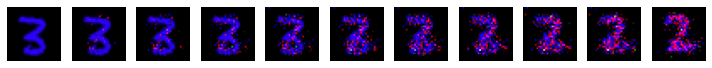

OT cost: tensor(0.7284, device='cuda:0')
Loss: 1.1402071714401245
Loss: 1.0737224817276
Loss: 1.1261593103408813
Loss: 1.1463531255722046
Loss: 1.1283425092697144
Loss: 1.1040973663330078
Loss: 1.0597761869430542
Loss: 1.142983317375183
Loss: 1.057584285736084
Loss: 1.0596307516098022


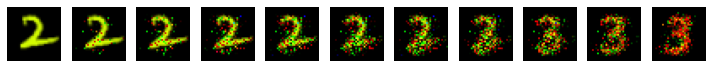

OT cost: tensor(0.7206, device='cuda:0')


  1%|          | 1/100 [39:00<64:21:56, 2340.57s/it]

Loss: 1.1140552759170532
Loss: 1.111581802368164
Loss: 1.1012678146362305
Loss: 1.1224884986877441
Loss: 1.084535002708435
Loss: 1.079192042350769
Loss: 1.0230095386505127
Loss: 1.0222078561782837
Loss: 1.0215744972229004
Loss: 0.9894881248474121


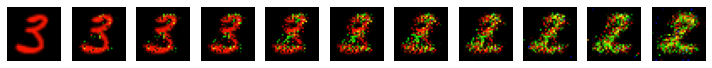

OT cost: tensor(0.6883, device='cuda:0')
Loss: 1.0759063959121704
Loss: 1.1008819341659546
Loss: 1.064032793045044
Loss: 1.0524195432662964
Loss: 1.07571542263031
Loss: 1.0624362230300903
Loss: 1.0369141101837158
Loss: 1.063228964805603
Loss: 1.0731343030929565
Loss: 1.044063687324524


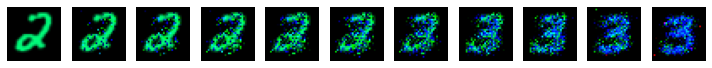

OT cost: tensor(0.7377, device='cuda:0')


  2%|▏         | 2/100 [1:18:02<63:44:33, 2341.57s/it]

Loss: 0.993039071559906
Loss: 1.010637879371643
Loss: 0.9685583710670471
Loss: 0.9824422001838684
Loss: 0.9775757789611816
Loss: 0.9990423321723938
Loss: 0.9551880955696106
Loss: 0.9582610130310059
Loss: 0.9551217555999756
Loss: 0.8423712253570557


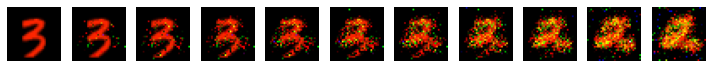

OT cost: tensor(0.6498, device='cuda:0')
Loss: 1.0694636106491089
Loss: 1.0843889713287354
Loss: 1.0536402463912964
Loss: 1.0496150255203247
Loss: 1.049118995666504
Loss: 1.0032881498336792
Loss: 0.9738262295722961
Loss: 0.9540534615516663
Loss: 0.9856862425804138


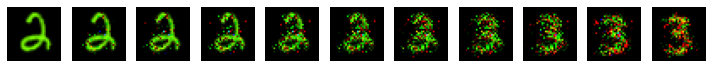

OT cost: tensor(0.6360, device='cuda:0')


  3%|▎         | 3/100 [1:57:04<63:05:41, 2341.66s/it]

Loss: 0.9020431637763977
Loss: 0.8804598450660706
Loss: 0.8535299301147461
Loss: 0.8783988356590271
Loss: 0.8419052958488464
Loss: 0.7949247360229492
Loss: 0.8206998705863953
Loss: 0.8392135500907898
Loss: 0.8172622323036194
Loss: 0.809629499912262


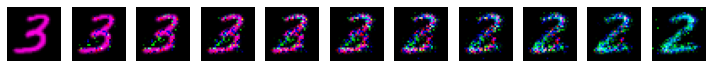

OT cost: tensor(0.7055, device='cuda:0')
Loss: 1.0034213066101074
Loss: 0.9977862238883972
Loss: 1.0145281553268433
Loss: 1.021933674812317
Loss: 1.0523654222488403
Loss: 1.0059032440185547
Loss: 1.0255099534988403
Loss: 1.0450172424316406
Loss: 1.0101317167282104
Loss: 1.0173979997634888


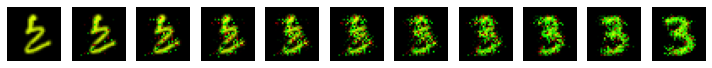

OT cost: tensor(0.6673, device='cuda:0')


  4%|▍         | 4/100 [2:36:07<62:27:11, 2341.99s/it]

Loss: 0.7690790295600891
Loss: 0.7579246163368225
Loss: 0.7200401425361633
Loss: 0.7044360041618347
Loss: 0.7595458030700684
Loss: 0.6907182335853577
Loss: 0.7607628703117371
Loss: 0.6473376154899597
Loss: 0.7028904557228088
Loss: 0.7005074620246887


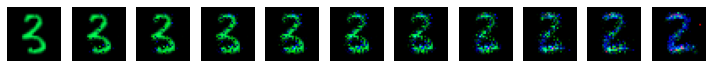

OT cost: tensor(0.6337, device='cuda:0')
Loss: 1.0265811681747437
Loss: 1.0076318979263306
Loss: 1.0435923337936401
Loss: 0.9901790022850037
Loss: 1.0069679021835327
Loss: 0.9824848771095276
Loss: 0.956758439540863
Loss: 1.0008606910705566
Loss: 0.9692628383636475
Loss: 0.9811758995056152


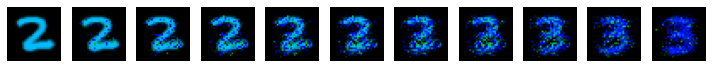

OT cost: tensor(0.6990, device='cuda:0')


  5%|▌         | 5/100 [3:15:10<61:48:41, 2342.33s/it]

Loss: 0.7197583317756653
Loss: 0.7330648303031921
Loss: 0.7226328253746033
Loss: 0.7302377223968506
Loss: 0.7129369378089905
Loss: 0.6365042924880981
Loss: 0.6328449845314026
Loss: 0.6219667792320251
Loss: 0.642257034778595
Loss: 0.96014803647995
Loss: 0.9691252112388611
Loss: 0.9965160489082336
Loss: 0.9570672512054443
Loss: 0.9985297322273254
Loss: 0.9797748923301697
Loss: 0.9999289512634277
Loss: 1.021558165550232
Loss: 0.9446641802787781
Loss: 0.9839741587638855


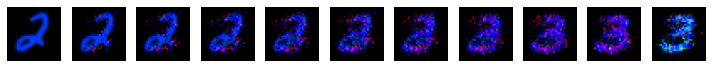

OT cost: tensor(0.7044, device='cuda:0')


  6%|▌         | 6/100 [3:54:14<61:10:57, 2343.16s/it]

Loss: 0.6292406320571899
Loss: 0.6632111072540283
Loss: 0.7203137278556824
Loss: 0.585175633430481
Loss: 0.6039080023765564
Loss: 0.7215938568115234
Loss: 0.7139009833335876
Loss: 0.6177960634231567
Loss: 0.6566187739372253
Loss: 0.5899878740310669


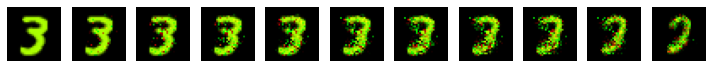

OT cost: tensor(0.5663, device='cuda:0')
Loss: 0.9552165865898132
Loss: 1.0069257020950317
Loss: 0.9901619553565979
Loss: 0.9496341347694397
Loss: 0.9060794711112976
Loss: 0.9445917010307312
Loss: 0.9855503439903259
Loss: 0.9646658897399902
Loss: 0.9601110816001892
Loss: 0.933239758014679


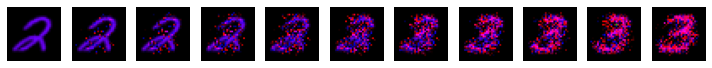

OT cost: tensor(0.7083, device='cuda:0')


  7%|▋         | 7/100 [4:33:20<60:33:03, 2343.91s/it]

Loss: 0.6155433058738708
Loss: 0.5468571186065674
Loss: 0.6421132683753967
Loss: 0.6461576819419861
Loss: 0.6517188549041748
Loss: 0.629188597202301
Loss: 0.6425192952156067
Loss: 0.6188169121742249
Loss: 0.6230657696723938
Loss: 0.6137539744377136


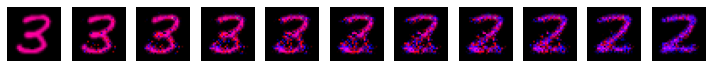

OT cost: tensor(0.4895, device='cuda:0')
Loss: 0.9740555286407471
Loss: 0.9688398838043213
Loss: 0.943263590335846
Loss: 0.9594656825065613
Loss: 0.9767649173736572
Loss: 0.9653511047363281
Loss: 1.010512351989746
Loss: 1.044103741645813
Loss: 0.9939821362495422
Loss: 1.004226565361023


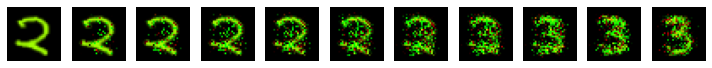

OT cost: tensor(0.6965, device='cuda:0')


  8%|▊         | 8/100 [5:12:23<59:53:39, 2343.69s/it]

Loss: 0.6412373781204224
Loss: 0.5265061259269714
Loss: 0.5448558926582336
Loss: 0.5576469302177429
Loss: 0.5329511165618896
Loss: 0.5863171815872192
Loss: 0.6064767837524414
Loss: 0.557083249092102
Loss: 0.6139160394668579
Loss: 0.6077343225479126


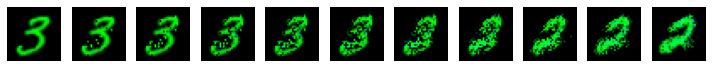

OT cost: tensor(0.5083, device='cuda:0')
Loss: 0.9873232245445251
Loss: 0.9819650650024414
Loss: 0.9167613387107849
Loss: 0.9778134822845459
Loss: 0.9552890658378601
Loss: 0.9162962436676025
Loss: 0.9006328582763672
Loss: 0.9612550735473633
Loss: 0.9702460765838623
Loss: 0.9618217349052429


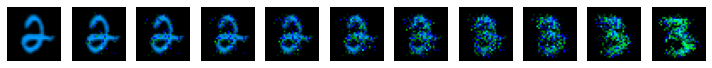

OT cost: tensor(0.6906, device='cuda:0')


  9%|▉         | 9/100 [5:51:28<59:15:18, 2344.16s/it]

Loss: 0.6575784683227539
Loss: 0.61601322889328
Loss: 0.6465819478034973
Loss: 0.5348113179206848
Loss: 0.4951866865158081
Loss: 0.48367783427238464
Loss: 0.4993259608745575
Loss: 0.5153439044952393
Loss: 0.5309196710586548
Loss: 0.5309072136878967


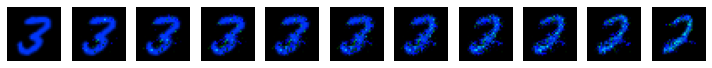

OT cost: tensor(0.5035, device='cuda:0')
Loss: 0.9791131019592285
Loss: 0.9858614802360535
Loss: 0.9844807982444763
Loss: 0.978041410446167
Loss: 0.9514399170875549
Loss: 0.9105873703956604
Loss: 0.9445235133171082
Loss: 0.9659173488616943
Loss: 0.9423174262046814
Loss: 0.8984055519104004


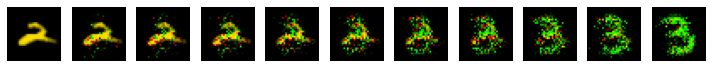

OT cost: tensor(0.6950, device='cuda:0')


 10%|█         | 10/100 [6:30:33<58:36:42, 2344.47s/it]

Loss: 0.5924426913261414
Loss: 0.6048867702484131
Loss: 0.5829655528068542
Loss: 0.562487781047821
Loss: 0.6457750201225281
Loss: 0.5264449715614319
Loss: 0.5543487668037415
Loss: 0.5990902781486511


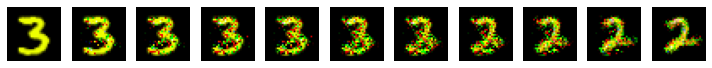

OT cost: tensor(0.5042, device='cuda:0')
Loss: 0.8960873484611511
Loss: 0.9120774269104004


In [ ]:
for i in tqdm(range(100)):
    N = 10
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * (int(t*100)+1)), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * (int(t*100)+1)), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    # torch.save(model_f, 'f_CMNIST.pt')
    # torch.save(model_b, 'b_CMNIST.pt')

In [22]:
torch.save(model_f, 'model_f.pt')

In [ ]:
torch.sqrt(((x_0 - x_1)**2)).mean()

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
import torch.nn.functional as F
import torch


def plot_trajectories(x0, xT, results):  
    N_points = 50
      
    fig, axes = plt.subplots(1, 3, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True, )

    
    n_steps = len(results)
    X_np = x0.cpu().numpy()

    lines = []
    for i in range(N_points):
        for j in range(n_steps-1):
            lines.append((results[j][0][i].cpu(), results[j+1][0][i].cpu()))
    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[1].add_collection(lc)
    axes[1].scatter(
        X_np[:N_points, 0], X_np[:N_points, 1], c='darkseagreen', edgecolors='black',
        zorder=2)
    
    for i in range(1, n_steps-1):
        axes[1].scatter(
        results[i][0][:N_points, 0].cpu().flatten(),
        results[i][0][:N_points, 1].cpu().flatten(),
        c='blue', edgecolors='blue', zorder=1, s=1
        )
    
    axes[1].scatter(
        results[-1][0][:N_points, 0].cpu().flatten(),
        results[-1][0][:N_points, 1].cpu().flatten(),
        c='wheat', edgecolors='black', zorder=3)
    
    
    
    
    
    X_np = x0.cpu().numpy()
    T_X_np = xT.cpu().numpy()
    
    PLOT_X_SIZE = X_np.shape[0]
    
    lines = []
    for i in range(PLOT_X_SIZE):
        lines.append((X_np[i], T_X_np[i]))

    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[0].add_collection(lc)
    axes[0].scatter(
        X_np[:PLOT_X_SIZE, 0], X_np[:PLOT_X_SIZE, 1], c='darkseagreen', edgecolors='black',
        zorder=2)
    axes[0].scatter(
        T_X_np[:PLOT_X_SIZE, 0].flatten(),
        T_X_np[:PLOT_X_SIZE, 1].flatten(),
        c='wheat', edgecolors='black', zorder=3)



    fig.tight_layout()
    return fig, axes

Визуализируем выученное отображение

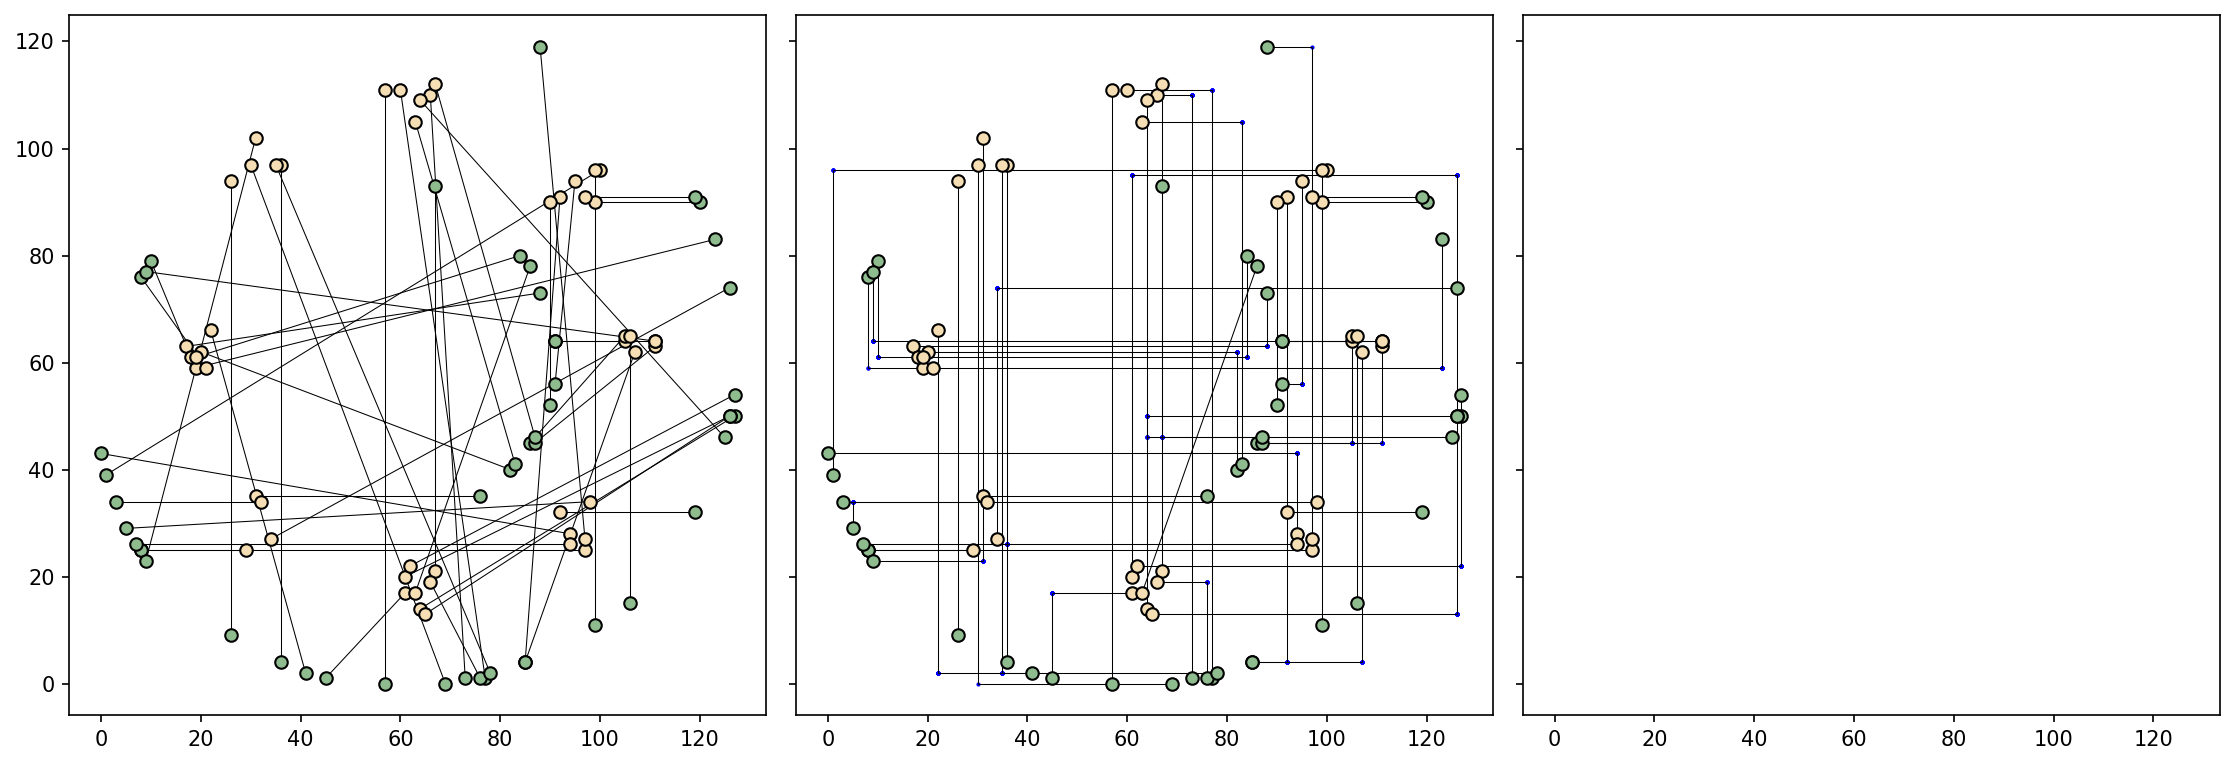

In [28]:
plot_trajectories(x_0[:50], x_1[:50], results)
None